In [1]:
!cp /content/drive/MyDrive/blocks.py .

cuda
Trainable parameters: 310,693 / 23841381 (1.30%)


Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.12it/s]

Epoch: 1/10, Train loss: 2.829414, Test loss: 0.001392, Accuracy: 95.39


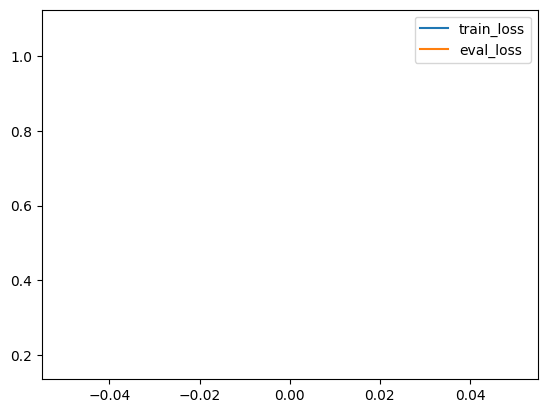

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.48it/s]


Epoch: 2/10, Train loss: 2.062716, Test loss: 0.000869, Accuracy: 96.08


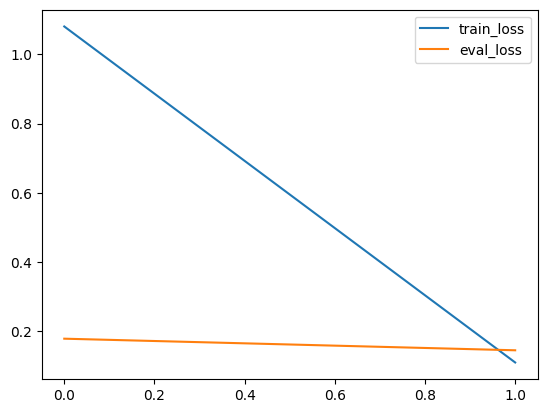

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.00it/s]


Epoch: 3/10, Train loss: 1.808283, Test loss: 0.000117, Accuracy: 96.77


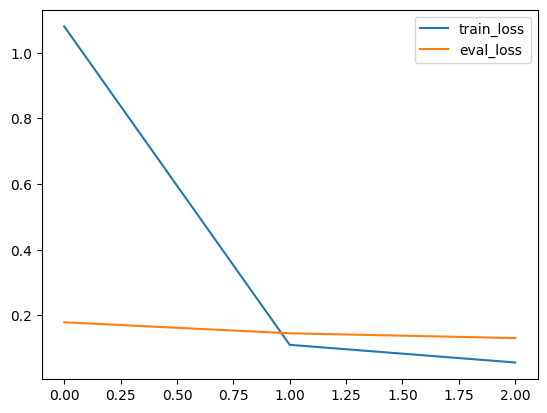

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 75.56it/s]


Epoch: 4/10, Train loss: 0.714368, Test loss: 0.000746, Accuracy: 96.77


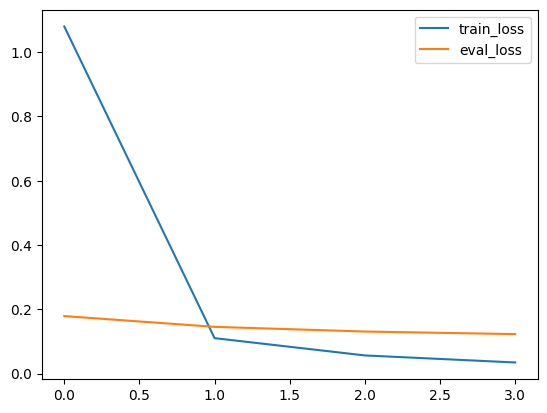

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 75.70it/s]


Epoch: 5/10, Train loss: 0.998166, Test loss: 0.000584, Accuracy: 96.42


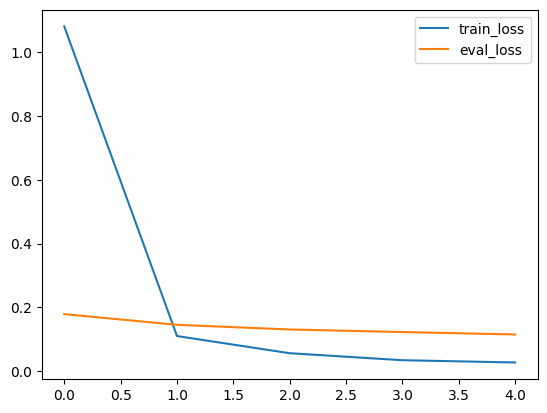

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 75.92it/s]


Epoch: 6/10, Train loss: 0.524594, Test loss: 0.000021, Accuracy: 97.23


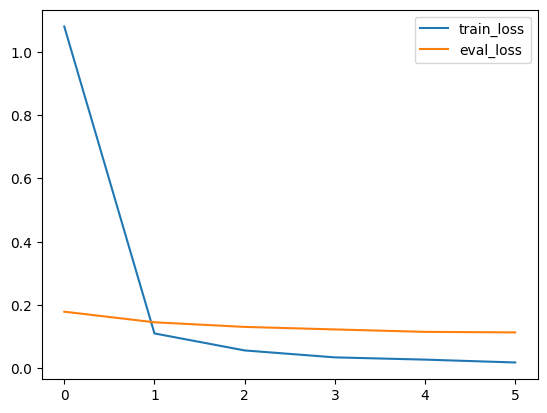

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.22it/s]


Epoch: 7/10, Train loss: 2.439330, Test loss: 0.000008, Accuracy: 96.77


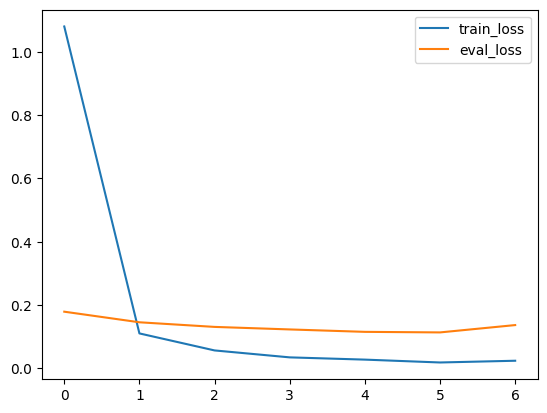

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.35it/s]


Epoch: 8/10, Train loss: 1.655470, Test loss: 0.000003, Accuracy: 96.89


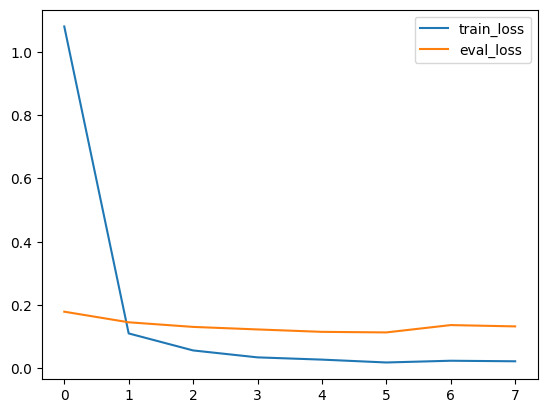

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 76.35it/s]


Epoch: 9/10, Train loss: 0.316473, Test loss: 0.000005, Accuracy: 96.66


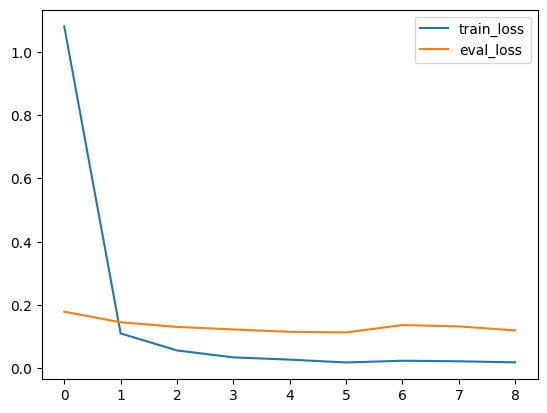

Evaluation: 100%|██████████| 867/867 [00:11<00:00, 75.71it/s]


Epoch: 10/10, Train loss: 0.709497, Test loss: 0.000016, Accuracy: 97.35


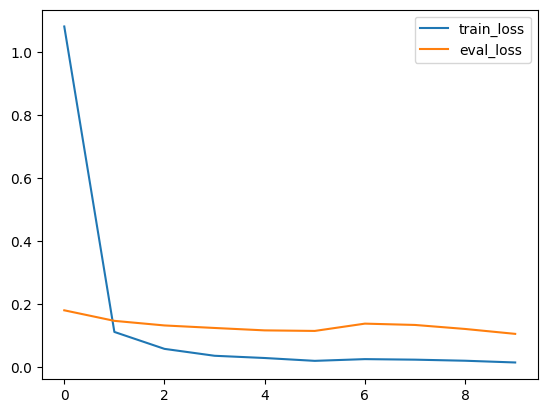

In [4]:
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from blocks import resnet34_peft, resnet50_peft, AdapterLayer, LoRALayer

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from matplotlib import pyplot as plt

import random

def train(model, train_dataloader, valid_dataloader, optim, loss_fn, num_epoch, device):
    train_epoch_losses = []
    eval_epoch_losses = []

    for epoch in range((num_epoch)):
        model.train()
        step_loss = []
        for data in tqdm(train_dataloader, desc="Training"):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optim.zero_grad()
            outputs = model(inputs)
            train_loss = loss_fn(outputs, labels)
            train_loss.backward()
            optim.step()
            step_loss.append(train_loss.item())
        train_epoch_losses.append(sum(step_loss) / len(step_loss))

        model.eval()
        total = 0
        correct = 0
        accuracy = []
        with torch.no_grad():
            step_loss = []
            for data in tqdm(valid_dataloader, desc="Evaluation"):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss = loss_fn(outputs, labels)
                accuracy.append(100 * correct/total)
                step_loss.append(test_loss.item())
            eval_epoch_losses.append(sum(step_loss) / len(step_loss))
        print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch+1, num_epoch, train_loss.item(), test_loss, 100*correct/total))

        plt.plot(train_epoch_losses, label='train_loss')
        plt.plot(eval_epoch_losses, label='eval_loss')
        plt.legend()
        plt.show()


def freeze_model(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)
    for name, module in model.named_modules():
        if isinstance(module, AdapterLayer):
            module.requires_grad_(True)
    for name, param in model.named_parameters():
        if 'lora_' in name:
            param.requires_grad = True
    n_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    n_total_params = sum(p.numel() for p in model.parameters())
    print(
        f"Trainable parameters: {n_trainable_params:,d} / {n_total_params} "
        f"({100 * n_trainable_params / n_total_params:.2f}%)"
    )


def main():
    seed = 42
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    model = resnet50_peft(lora_r=1, adapter_r=0) #### test ####
    transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize([0.5487, 0.5313, 0.5050], [0.2497, 0.2467, 0.2483]),
        v2.Resize((224, 224)),
        v2.RGB(),
    ])
    dataset = datasets.Caltech101('/content/drive/MyDrive/Colab Notebooks/data', transform=transform)
    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset,
        [0.9, 0.1],
        torch.Generator().manual_seed(42)
    )

    # Hyperparameters
    num_classes = 101
    batch_size = 32
    epochs = 10
    learning_rate = 0.001

    # model
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    freeze_model(model)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False
    )

    loss_fn = nn.CrossEntropyLoss()

    train(model, train_loader, valid_loader, optimizer, loss_fn, epochs, device)


if __name__ == "__main__":
    main()